# This notebook trains Essemble CNN to recognize the digits in MNIST. The data is from Kaggle [Digit-recognizer competition](https://www.kaggle.com/c/digit-recognizer). Please past the `train.csv` and `test.csv` on `/kaggle/input/digit-recognizer/` folder to run this notebook. 

In [1]:
import torch
import torchvision


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import copy
import time

In [2]:
torch.backends.cudnn.enabled

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Configs

In [4]:
import os
os.listdir("/kaggle/")

['src', 'lib', 'input', 'working']

In [5]:
Num_CNN = 12

n_epochs = 25
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 121
torch.manual_seed(random_seed)

kaggle_input_data = "/kaggle/input/digit-recognizer/train.csv"
kaggle_input_validation = "/kaggle/input/digit-recognizer/test.csv"

kaggle_model_path = "/kaggle/working/model_id_%d.pth"
kaggle_optimizer_path = "/kaggle/working/optimizer_id_%d.pth"
prediction_path = "/kaggle/working/predictions_essemble.csv"

# Dataset

In [6]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, dataframe):
        # initisalization
        self.labels = dataframe["label"].to_numpy()
        self.dataframe = dataframe.loc[:,dataframe.columns != "label"]
    
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, index):
        # generate one sample of data - reshaping array to 28x28
        X = torch.from_numpy(self.dataframe.iloc[index].values.reshape(1,28,28)).float()
        y = self.labels[index]
        
        return X,y

In [7]:
df_input = pd.read_csv(kaggle_input_data)
df_validation = pd.read_csv(kaggle_input_validation)

df_train, df_test = train_test_split(df_input, test_size  = 0.01)

# training
training_set = Dataset(df_train)
training_generator = torch.utils.data.DataLoader(training_set, batch_size = batch_size_train,
                                                shuffle = True)

# test
test_set = Dataset(df_test)
test_generator = torch.utils.data.DataLoader(test_set, batch_size = batch_size_test,
                                                shuffle = True)

# validation 
kaggle_validation_set = torch.from_numpy(df_validation.to_numpy()).view(
    df_validation.shape[0],-1,28,28).float()

# Looking at some examples

## Train examples

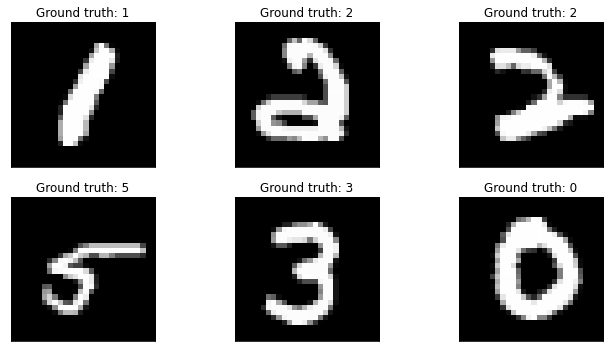

In [8]:
examples = enumerate(test_generator)
batch_idx, (example_data, example_labels) = next(examples)


fig = plt.figure(figsize = (10,5))
for i in range(6):
    ax = fig.add_subplot(2,3, i+1)
    ax.imshow(example_data[i][0], cmap = "gray", interpolation = "none")
    ax.set_title(f"Ground truth: {example_labels[i]}")
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.show()

## Validation examples

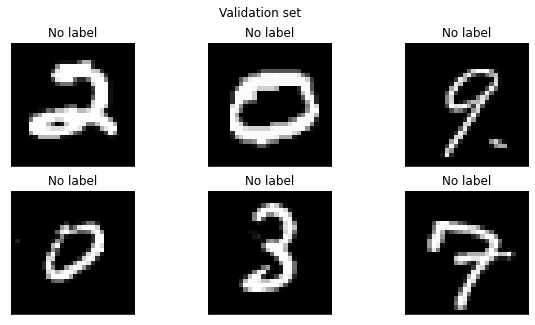

In [9]:
fig = plt.figure(figsize = (10, 5))
for i in range(6):
    ax = fig.add_subplot(2,3, i+1)
    ax.imshow(kaggle_validation_set[i][0], cmap = "gray", interpolation = "none")
    ax.set_title("No label")
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("Validation set")
fig.show()

# Build the network

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Conv 1
        # size : input: 28x28x1 -> output : 26 x 26 x 32
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.batchnorm1 = nn.BatchNorm2d(32)
        
        # Conv 2
        # size : input: 26x26x32 -> output : 24 x 24 x 32
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        # Conv 3
        # size : input: 24x24x32 -> output : 12 x 12 x 32
        self.conv3 = nn.Conv2d(32, 32, kernel_size=2, stride = 2)
        self.batchnorm3 = nn.BatchNorm2d(32)
        
        # Conv 4
        # size : input : 12 x 12 x 32 -> output : 8 x 8 x 64
        self.conv4 = nn.Conv2d(32, 64, kernel_size=5)
        self.batchnorm4 = nn.BatchNorm2d(64)
        
        # Conv 5
        # size : input: 8x8x64 -> output : 4 x 4 x 64 -> Linearize = 1024
        self.conv5 = nn.Conv2d(64, 64, kernel_size=2, stride = 2)
        self.batchnorm5 = nn.BatchNorm2d(64)
        
        # dropout layer 
        self.conv5_drop = nn.Dropout2d()
        
        # FC 1 
        self.fc1 = nn.Linear(1024, 128)
        
        # FC 2
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = self.batchnorm4(F.relu(self.conv4(x)))
        x = self.batchnorm5(F.relu(self.conv5(x)))
        x = self.conv5_drop(x)
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

## Train the model

In [12]:
train_losses = []
train_counter = []

test_losses = []

test_counter = [i*len(training_generator.dataset) for i in range(n_epochs + 1)]

# only print on the last batch
log_interval = len(training_generator)

# network_list 
network_list = []

# output tensor
prediction_tensor = torch.zeros(kaggle_validation_set.shape[0],10)

In [13]:
def train(epoch, network, scheduler, network_id, device):
    start_time = time.time()
    
    network.train()
    for batch_idx, (data, target) in enumerate(training_generator):
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        
        output = network(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
    
    print('CNN : {},\t Train Epoch: {} \tLoss: {:.6f},\t runtime: {:.2f}'.format(
        network_id,
        epoch, loss.item(), time.time()-start_time))
    
    train_losses.append(loss.item())
    train_counter.append(epoch)

    torch.save(network.state_dict(), kaggle_model_path%network_id)
    torch.save(optimizer.state_dict(),kaggle_optimizer_path%network_id)
    scheduler.step()


def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_generator:
            data = data.to(device)
            target = target.to(device)
            
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction="sum").item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            
    test_loss /= len(test_generator.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)\n'.format(
                test_loss, correct, len(test_generator.dataset),
                100. * correct / len(test_generator.dataset)))


def validation(network, validation_tensor, prediction_tensor):
    
    with torch.no_grad():
        output = network(validation_tensor)
    
    prediction_tensor = prediction_tensor + output
    
    return prediction_tensor



def initialise_network(device):
    network = Net().to(device)
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum = momentum)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.95)
    
    return network, optimizer, exp_lr_scheduler

### Initialise the network and train

In [14]:
validation_tensor = kaggle_validation_set.to(device)
prediction_tensor = prediction_tensor.to(device)


for id_net in range(1, Num_CNN+1):
    
    network, optimizer, scheduler = initialise_network(device)
    
    for epoch in range(1, n_epochs+1):
        train(epoch, network, scheduler, id_net, device)
    test(network)
    
    prediction_tensor = validation(network, validation_tensor, prediction_tensor)
    network_list.append(copy.deepcopy(network))

CNN : 1,	 Train Epoch: 1 	Loss: 0.041862,	 runtime: 12.55
CNN : 1,	 Train Epoch: 2 	Loss: 0.048314,	 runtime: 11.66
CNN : 1,	 Train Epoch: 3 	Loss: 0.017722,	 runtime: 10.93
CNN : 1,	 Train Epoch: 4 	Loss: 0.030813,	 runtime: 11.48
CNN : 1,	 Train Epoch: 5 	Loss: 0.005597,	 runtime: 10.91
CNN : 1,	 Train Epoch: 6 	Loss: 0.040222,	 runtime: 10.86
CNN : 1,	 Train Epoch: 7 	Loss: 0.009441,	 runtime: 12.97
CNN : 1,	 Train Epoch: 8 	Loss: 0.003533,	 runtime: 10.84
CNN : 1,	 Train Epoch: 9 	Loss: 0.000497,	 runtime: 10.85
CNN : 1,	 Train Epoch: 10 	Loss: 0.005570,	 runtime: 11.58
CNN : 1,	 Train Epoch: 11 	Loss: 0.006692,	 runtime: 11.10
CNN : 1,	 Train Epoch: 12 	Loss: 0.030022,	 runtime: 11.95
CNN : 1,	 Train Epoch: 13 	Loss: 0.000580,	 runtime: 11.48
CNN : 1,	 Train Epoch: 14 	Loss: 0.001744,	 runtime: 10.82
CNN : 1,	 Train Epoch: 15 	Loss: 0.004347,	 runtime: 10.78
CNN : 1,	 Train Epoch: 16 	Loss: 0.004989,	 runtime: 11.42
CNN : 1,	 Train Epoch: 17 	Loss: 0.026992,	 runtime: 11.43
CNN : 

# Output predictions

In [15]:
# calculating the labels and moving prediciton to cpu
output_df = prediction_tensor.max(1)[1].to("cpu")

output_df = pd.DataFrame(output_df.numpy(), columns = ["Label"])

output_df.index.name = "ImageId"
output_df.index = output_df.index + 1

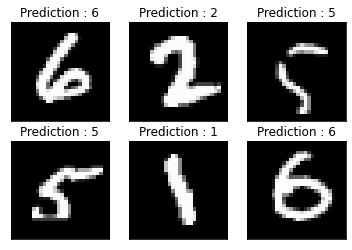

In [16]:
start_pos = 34

fig = plt.figure()
for i in range(6):
    ax = fig.add_subplot(2,3, i+1)
    ax.imshow(kaggle_validation_set[start_pos+i][0], cmap = "gray", interpolation = "none")
    ax.set_title(f"Prediction : {output_df.iloc[start_pos+i][0]}")
    ax.set_xticks([])
    ax.set_yticks([])

# Saving the predictions

In [17]:
output_df

,Label
ImageId,
1,2
2,0
3,9
4,9
5,3
...,...
27996,9
27997,7
27998,3


In [18]:
output_df.to_csv(prediction_path)

# Score of 0.99350 on kaggle. Data augmentation can help increase the score to 0.997+ for CNN methods. Can be tried later. 